In [2]:
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import numpy as np

warnings.filterwarnings("ignore")

# Load the dataset
dp = pd.read_csv("Data/T1.csv")
# dp.describe()
# df.head()

In [3]:
df = dp[:10000]

In [4]:
dp.head()

,Date/Time,LV ActivePower (kW),Wind Speed (m/s),Theoretical_Power_Curve (KWh),Wind Direction (°)
0,01 01 2018 00:00,380.047791,5.311336,416.328908,259.994904
1,01 01 2018 00:10,453.769196,5.672167,519.917511,268.641113
2,01 01 2018 00:20,306.376587,5.216037,390.900016,272.564789
3,01 01 2018 00:30,419.645905,5.659674,516.127569,271.258087
4,01 01 2018 00:40,380.650696,5.577941,491.702972,265.674286


In [6]:
df['Date/Time'] = pd.to_datetime(df['Date/Time'], format="%d %m %Y %H:%M")
df['Month'] = df['Date/Time'].dt.month
df['Week'] = df['Date/Time'].dt.isocalendar().week
df['day'] = df['Date/Time'].dt.day
df['Hour'] = df['Date/Time'].dt.hour
df['Min'] = df['Date/Time'].dt.minute

# df.head(4)

In [7]:
All_data=df.drop(columns=['Date/Time'])
# All_data.head()
D=np.array(All_data)
# D

In [33]:
# D

In [9]:
# Define features and target
target_column = 'LV ActivePower (kW)'  # Assuming 'Power' is the column to predict
target = D[:, 0]
features = np.delete(D, 8, axis=1)


In [10]:
features = D[:,:]
print(target.shape ,features.shape )

(10000,) (10000, 9)


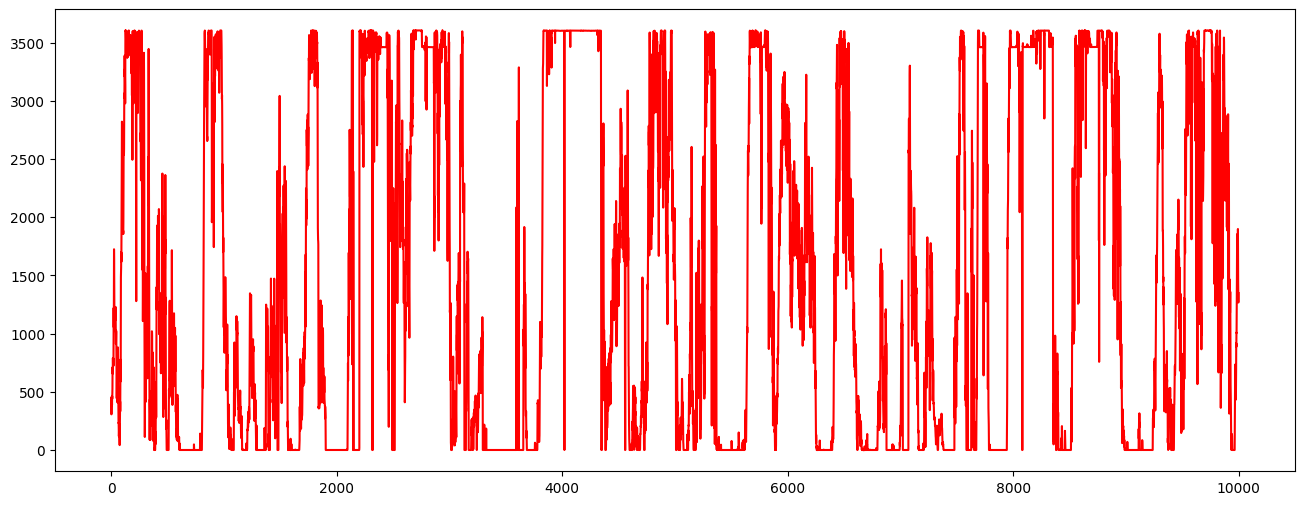

In [11]:
plt.figure(figsize=(16,6))
plt.plot(target,'r',label='train')
plt.show()

In [67]:
# features

In [12]:
from sklearn.preprocessing import MinMaxScaler

# Initialize the scaler and fit to the dataset
scaler_01 = MinMaxScaler()
features_scaled = scaler_01.fit_transform(features)


In [13]:
scaler_02 = MinMaxScaler()
W=target.reshape(-1, 1)
W
target_scaled = scaler_02.fit_transform(W)

In [14]:
# target_scaled

In [40]:
# import pandas as pd
# from sklearn.impute import KNNImputer
# from sklearn.preprocessing import StandardScaler

# # Load your dataset
# # data = pd.read_csv("wind_turbine_data.csv")

# # Separate timestamp column if needed
# timestamps = df['Date']  # Assuming your timestamp column is named 'Date'
# data = df.drop(columns=['Date'])

# # Optional: Scale the data before imputation (especially useful if features have different scales)
# scaler = StandardScaler()
# data_scaled = pd.DataFrame(scaler.fit_transform(data), columns=data.columns)

# # Initialize and apply KNNImputer
# imputer = KNNImputer(n_neighbors=5)
# data_imputed = imputer.fit_transform(data_scaled)  # Returns a NumPy array

# # Convert back to DataFrame and revert scaling if needed
# data_imputed = pd.DataFrame(data_imputed, columns=data.columns)
# data_imputed = pd.DataFrame(scaler.inverse_transform(data_imputed), columns=data.columns)

# # Reattach timestamp column
# data_imputed['Date'] = timestamps


In [15]:
timesteps = 4  # Number of past time steps to include

X, y = [], []
for i in range(timesteps, len(features_scaled)):
    X.append(features_scaled[i - timesteps:i])
    y.append(target_scaled[i])

X, y = np.array(X), np.array(y)


In [16]:
train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]


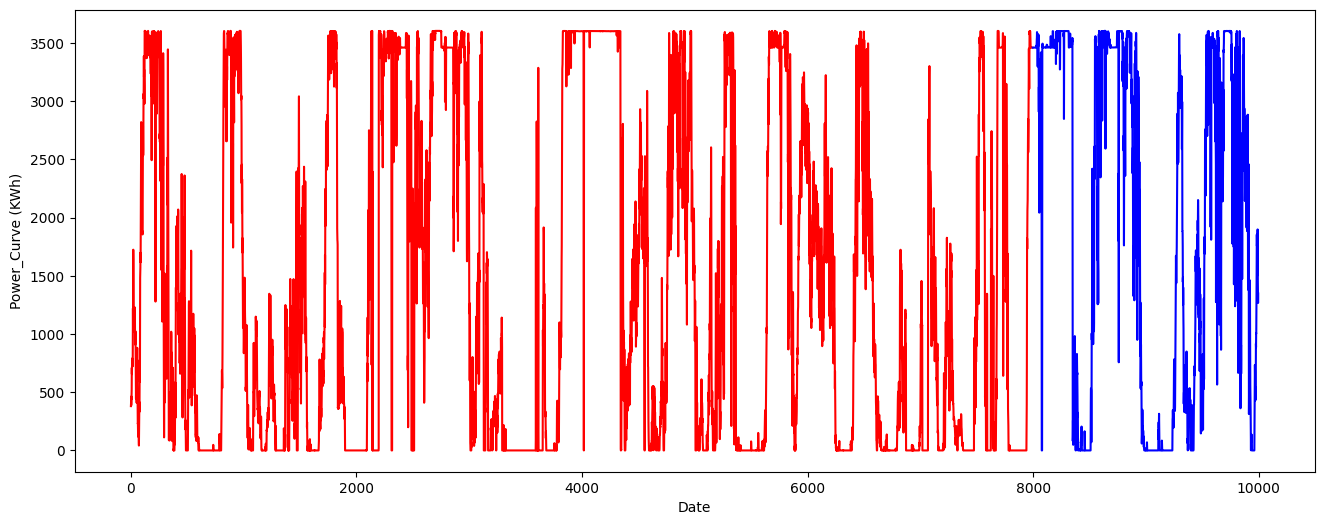

In [18]:
from matplotlib import pyplot as plt

test_x_range=np.arange(train_size ,len(X),1)
#test_x_range is an array of values between 1000-1208
plt.figure(figsize=(16,6))
plt.plot(scaler_02.inverse_transform(y_train),'r',label='train')
plt.plot(test_x_range,scaler_02.inverse_transform(y_test),'b',label='test')
plt.xlabel('Date')
plt.ylabel('Power_Curve (KWh)')
plt.show()

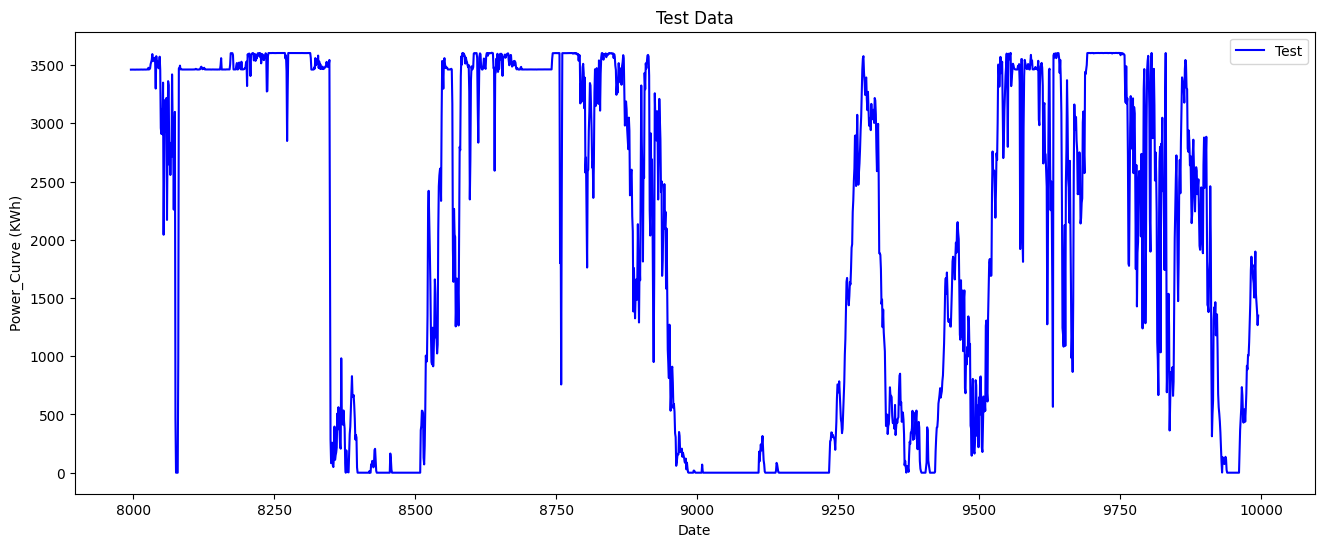

In [23]:
plt.figure(figsize=(16,6))
plt.plot(test_x_range,scaler_02.inverse_transform(y_test),'b',label='Test')
plt.xlabel('Date')
plt.ylabel('Power_Curve (KWh)')
plt.legend()
plt.title('Test Data')
plt.show()

In [74]:
import tensorflow.keras.backend as K

def r_squared(y_true, y_pred):
    ss_res = K.sum(K.square(y_true - y_pred))
    ss_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return 1 - ss_res / (ss_tot + K.epsilon())

In [75]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam,SGD

# # Define the LSTM model architecture
model = Sequential()
model.add(LSTM(48, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))  # Dropout layer to prevent overfitting

model.add(LSTM(48, return_sequences=False))
model.add(Dropout(0.2))

# model.add(Dense(25, activation='relu'))
model.add(Dense(1))  # Output layer for regression (predicting power output)

opt = Adam(0.0001, clipnorm=1.0)
# # Compile the model
# model.compile(optimizer=opt, loss='mean_squared_error',metrics=['mae','mse',r_squared])
model.compile(optimizer=opt, loss='mean_squared_error',metrics=['mae','mse'])
model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 4, 48)             11136     
                                                                 
 dropout_4 (Dropout)         (None, 4, 48)             0         
                                                                 
 lstm_5 (LSTM)               (None, 48)                18624     
                                                                 
 dropout_5 (Dropout)         (None, 48)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 49        
                                                                 
Total params: 29,809
Trainable params: 29,809
Non-trainable params: 0
_________________________________________________________________


In [46]:
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization

# # Define the LSTM model architecture
# model = Sequential()
# model.add(LSTM(128, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
# model.add(BatchNormalization())
# model.add(Dropout(0.3))  # Dropout layer to prevent overfitting

# model.add(LSTM(units=96,return_sequences=True))
# model.add(BatchNormalization())
# model.add(Dropout(0.3))

# model.add(LSTM(units=64,return_sequences=True))
# model.add(BatchNormalization())
# model.add(Dropout(0.2))

# model.add(LSTM(units=32,return_sequences=False))
# model.add(BatchNormalization())
# model.add(Dropout(0.2))

# model.add(Dense(64, activation='relu'))
# model.add(Dropout(0.2))
# model.add(Dense(32, activation='relu'))
# # Output layer
# model.add(Dense(1, activation='linear'))

# model.compile(loss='mse',optimizer='adam',metrics=['mae','mse',r_squared])
# model.summary()


In [76]:
from tensorflow.keras.callbacks import EarlyStopping

# Early stopping to stop training when a monitored metric has stopped improving
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train, 
                    epochs=30, 
                    batch_size=4, 
                    # validation_split=0.1, )            
                    validation_data=(X_test, y_test), )
                    # callbacks=[early_stop])


Epoch 1/30
1999/1999 [==============================] - 20s 9ms/step - loss: 0.0371 - mae: 0.1283 - mse: 0.0371 - val_loss: 0.0168 - val_mae: 0.0886 - val_mse: 0.0168
Epoch 2/30
1999/1999 [==============================] - 18s 9ms/step - loss: 0.0155 - mae: 0.0831 - mse: 0.0155 - val_loss: 0.0133 - val_mae: 0.0713 - val_mse: 0.0133
Epoch 3/30
1999/1999 [==============================] - 17s 9ms/step - loss: 0.0140 - mae: 0.0778 - mse: 0.0140 - val_loss: 0.0126 - val_mae: 0.0684 - val_mse: 0.0126
Epoch 4/30
1999/1999 [==============================] - 20s 10ms/step - loss: 0.0133 - mae: 0.0749 - mse: 0.0133 - val_loss: 0.0118 - val_mae: 0.0635 - val_mse: 0.0118
Epoch 5/30
1999/1999 [==============================] - 26s 13ms/step - loss: 0.0124 - mae: 0.0720 - mse: 0.0124 - val_loss: 0.0115 - val_mae: 0.0655 - val_mse: 0.0115
Epoch 6/30
1999/1999 [==============================] - 26s 13ms/step - loss: 0.0120 - mae: 0.0707 - mse: 0.0120 - val_loss: 0.0109 - val_mae: 0.0635 - val_mse: 0.

In [48]:
# # Predict on test set
# predictions = model.predict(X_test)

# # Rescale the predictions and actual values to their original scale if needed
# y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))
# predictions_rescaled = scaler.inverse_transform(predictions)

# # Calculate error metrics
# from sklearn.metrics import mean_squared_error
# mse = mean_squared_error(y_test_rescaled, predictions_rescaled)
# print("Mean Squared Error:", mse)


In [78]:
from sklearn.metrics import r2_score

result=model.predict(X_test)
# result
r2=r2_score(y_test,result)
print(f'R2 score:{r2*100:2f}')
# 0.8641384950615951

R2 score:96.143809


In [90]:
# 2. Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test, result)

# 3. Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, result)

print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")

Mean Squared Error (MSE): 0.006570064504825435
Mean Absolute Error (MAE): 0.041935763972264735


In [88]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

real_y_test = scaler_02.inverse_transform(y_test)
real_results = scaler_02.inverse_transform(result)

r2=r2_score(real_y_test,real_results)
print('R2 score:',r2)

# 2. Calculate Mean Squared Error (MSE)
mse = mean_squared_error(real_y_test, real_results)

# 3. Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(real_y_test, real_results)

print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")



R2 score: 0.9614380867660082
Mean Squared Error (MSE): 85537.77367571277
Mean Absolute Error (MAE): 151.31385497699893


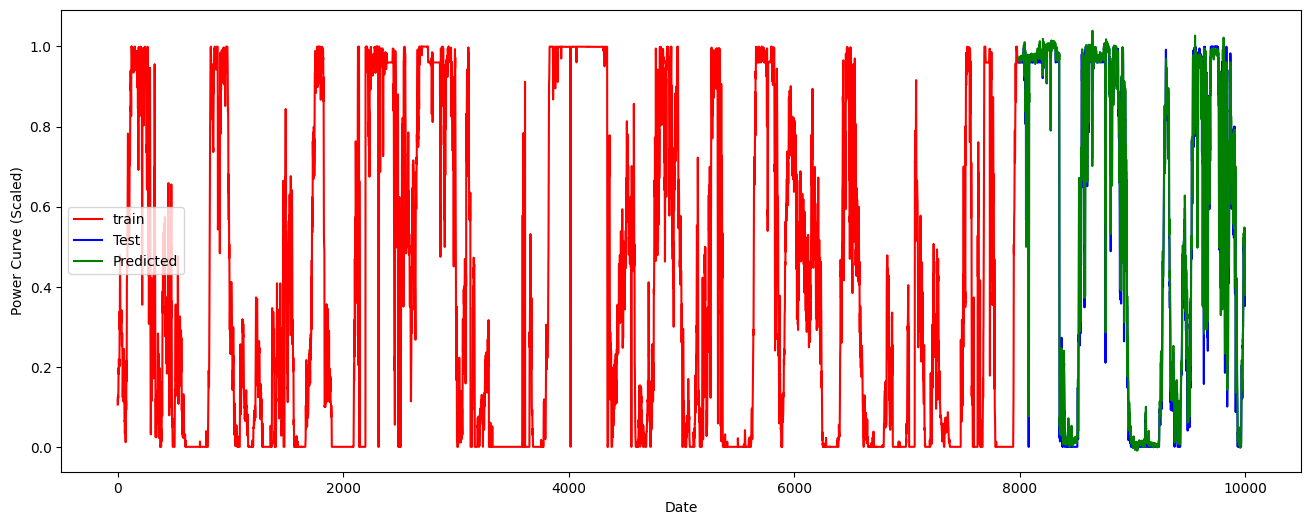

In [85]:
test_x_range=np.arange(train_size ,len(X),1)
plt.figure(figsize=(16,6))
plt.plot(y_train,'r',label='train')
plt.plot(test_x_range,y_test,'b',label='Test')
plt.plot(test_x_range,result,'g',label='Predicted')

plt.xlabel('Date')
plt.ylabel('Power Curve (Scaled)')
plt.legend()
plt.show()

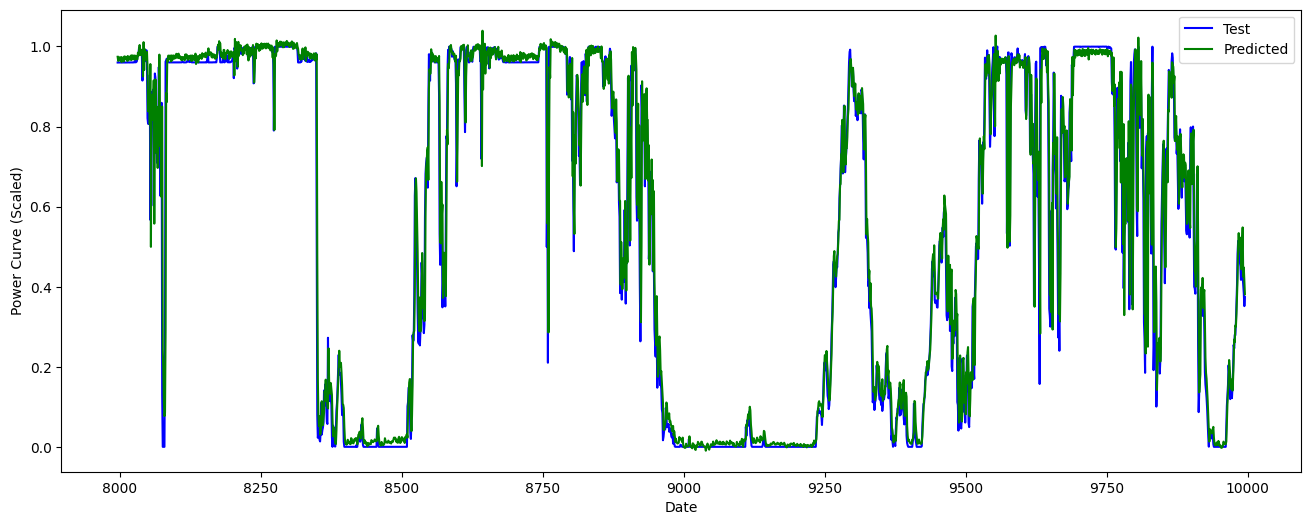

In [86]:
test_x_range=np.arange(train_size ,len(X),1)
plt.figure(figsize=(16,6))
# plt.plot(y_train,'r',label='train')
plt.plot(test_x_range,y_test,'b',label='Test')
plt.plot(test_x_range,result-0.00,'g',label='Predicted')
plt.xlabel('Date')
plt.ylabel('Power Curve (Scaled)')
plt.legend()
plt.show()

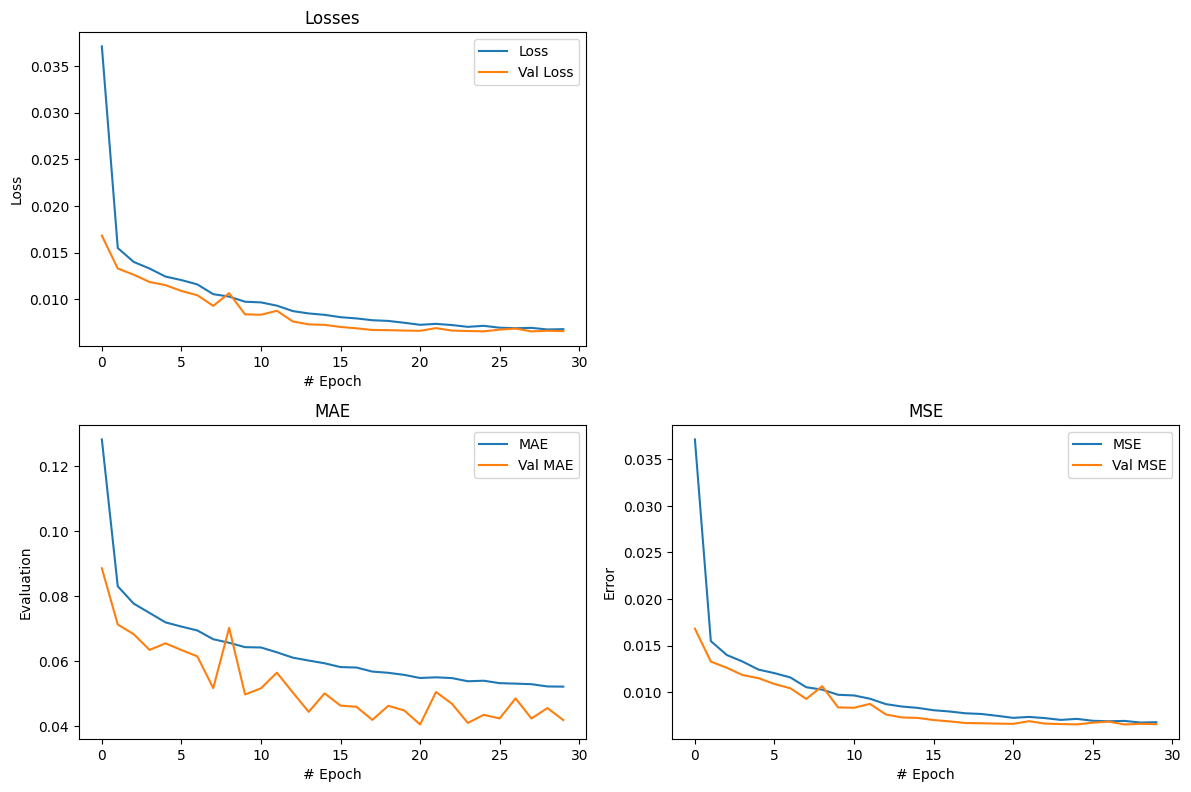

In [87]:
from matplotlib import pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 8))

# plt.subplot(2, 2, 4)
# plt.plot(history.history["r_squared"],label='R2')
# plt.plot(history.history["val_r_squared"],label='Val R2')
# plt.legend()
# plt.ylabel('R2')
# plt.xlabel('# Epoch')
# plt.title('R2 Score')

plt.subplot(2, 2, 1)
plt.plot(history.history['loss'],label='Loss')
plt.plot(history.history['val_loss'],label='Val Loss')
plt.legend()
plt.xlabel('# Epoch')
plt.ylabel('Loss')
plt.title('Losses')

plt.subplot(2, 2, 4)
plt.plot(history.history['mse'],label='MSE')
plt.plot(history.history['val_mse'],label='Val MSE')
plt.legend()
plt.ylabel('Error')
plt.xlabel('# Epoch')
plt.title('MSE')

plt.subplot(2, 2, 3)
plt.plot(history.history["mae"],label='MAE')
plt.plot(history.history["val_mae"],label='Val MAE')
plt.legend()
plt.ylabel('Evaluation')
plt.xlabel('# Epoch')
plt.title('MAE')

plt.tight_layout(pad=1)
# plt.savefig("Results.png")
# plt.show()

# x = model.evaluate(test_data, test_target)
# print("\n",round(x[1]*100,2),"%")

In [63]:
from sklearn.metrics import mean_absolute_error
import numpy as np

# Define a function for permutation importance
def permutation_importance(model, X_test, y_test):
    baseline = mean_absolute_error(y_test, model.predict(X_test))
    importances = []
    
    for i in range(X_test.shape[2]):  # Iterate over features
        X_permuted = X_test.copy()
        np.random.shuffle(X_permuted[:, :, i])  # Shuffle the ith feature
        permuted_mae = mean_absolute_error(y_test, model.predict(X_permuted))
        importance = permuted_mae - baseline  # Compute importance as the drop in performance
        importances.append(importance)
    
    return np.array(importances)

# Example usage:
feature_importances = permutation_importance(model, X_test, y_test)
print("Feature importances:", feature_importances)


Feature importances: [ 3.83631763e-01  8.85054393e-03  6.39648032e-03  2.00734751e-04
  0.00000000e+00 -2.67489932e-05  1.29069363e-05 -1.77784051e-04]


In [64]:
for i in feature_importances:
    print(i * 100)

38.36317627916874
0.885054392597566
0.6396480323307502
0.020073475059049356
0.0
-0.002674899318938495
0.0012906936326675944
-0.017778405128165975
